<a href="https://colab.research.google.com/github/brunoalbrito/TensorFlowTrafficSignsRecognition/blob/master/MinhaVersao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reconhecimento de Sinalização de Trânsito com TensorFlow**


Esse notebook é uma reescrita de uma versão já criada de reconhecimento de sinalização de trânsito com **TensorFlow**

**Primeiro objetivo: Classificar as sinalizações de trânsito**

In [0]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Permite embutir imagem no notebook
%matplotlib inline

###Testando Matplotlib

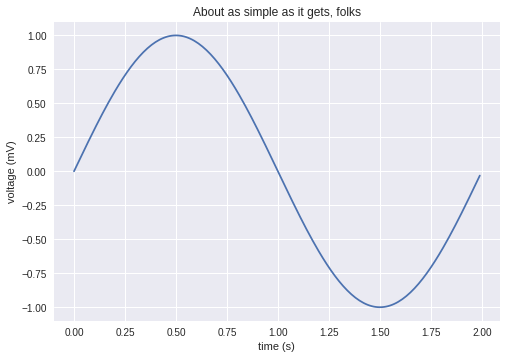

In [42]:
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(1*np.pi*t)
plt.plot(t, s)

plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.title('About as simple as it gets, folks')
plt.grid(True)
plt.savefig("test.png")
plt.show()

##Primeiro Passo

O objetivo inicial é a classificação, onde dado um sinal de transito, o modelo deve ser capaz de dizer o tipo, ex: Pare, limite de velocidade, preparado para parar. 

Primeiro vou testar o carregamento de um arquivo do Google Drive:

In [32]:
from google.colab import drive

'''
diz que se for necessario usar no montante do drive os arquivos pedidos para leitora e escrita
'''
drive.mount('/content/gdrive')

with open('/content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Learning/foo.txt', 'r') as f:
  print(f.read())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Hello My Drive
Tentando leitura de arquivo


Agora vou testar a leitura de imagem e apresentação da imagem com numpy e matplotlib

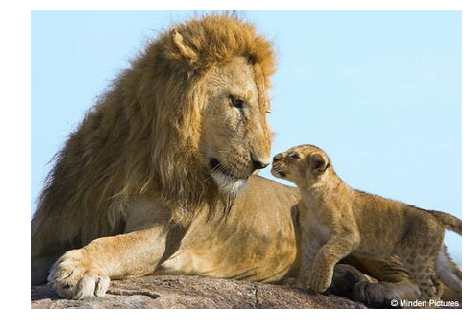

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Learning/lion.jpeg',1)

fig, ax = plt.subplots()
ax.axis('off')#remove as linhas
'''
OpenCv representa as imagens em BGR por isso é preciso converter
RGB para BGR: de onde tirei a resposta
https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
'''
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()